In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics

from metric import pr_score, steps
from utils import _check_equation_format, _check_number_format, calculate, check_format, convert_base

In [2]:
sessions_dir = "models/chatgpt/sessions"
dataset = "tra0"
model = "gpt-4o"
num_from_dataset = 10
base_range = (2, 17)
session = f'{dataset}_{model}_{num_from_dataset}-{base_range[0]}-{base_range[1]}'
format = "process"
session_data = pd.read_csv(f'{sessions_dir}/{session}/{session}_{format}_formatted.csv')

In [3]:
## put responses into two lists (questions, responses) and parse them
questions = []
responses = []
for i, row in session_data.iterrows():
    for base in range(base_range[0], base_range[1]):
        questions.append(row[f'equation_{{{base}}}'][:-1])
        if pd.isna(row[f'answer_{{{base}}}']):
            responses.append([])
        else:
            responses.append(row[f'answer_{{{base}}}'].split("="))

In [4]:
## check formats of the responses

# check format of each equation and response
print("questions or responses that have incorrect formats: ")
for question in questions:
    try:
        _check_equation_format(question)
    except:
        print(question)
for response in responses:
    for equation in response:
        if len(check_format(equation)) == 0:
            print(equation)
print()

# check if initial equation of response match original question
print("responses whose first equation don't match their original questions: ")
for question, response in zip(questions, responses):
    if len(response) == 0 or question != response[0]:
        print(f"question: {question}\tresponse: {response}")

questions or responses that have incorrect formats: 

responses whose first equation don't match their original questions: 


In [5]:
print("pr_ratio\tpr_score")
responses_score, _ = pr_score(questions, responses, pr_ratio=0)
print(f"0\t\t\t{responses_score}", )
responses_score, graded_responses = pr_score(questions, responses)
print(f"0.4\t\t\t{responses_score}")
responses_score, _ = pr_score(questions, responses, pr_ratio=1)
print(f"1\t\t\t{responses_score}")
print("*pr_score: process_score * pr_ratio + y_correct * (1 - pr_ratio)")
print("*pr_ratio of 0 is not looking at process and 1 is only looking at process: pr_ratio increase -> process more important")

pr_ratio	pr_score
0			0.32
0.4			0.45999999999999974
1			0.6700000000000006
*pr_score: process_score * pr_ratio + y_correct * (1 - pr_ratio)
*pr_ratio of 0 is not looking at process and 1 is only looking at process: pr_ratio increase -> process more important


# Evaluate process_graded

In [6]:
print("example question (x) and graded response (y): ")
def display_process_graded(n):
    print(f"'x': {questions[n]}")
    print_dict = {}
    print_dict.update(graded_responses[questions[n]])
    print_dict.pop('y_process')
    print(print_dict)
    print("y_process: ")
    display(graded_responses[questions[n]]['y_process'])

display_process_graded(0)

print("graded keys:", graded_responses[questions[0]].keys())
print("y_process: graded details of each step\n"
      "x_correct: is it calculating the right question? \n"
      "y_correct: score of final answer\n"
      "process_score: score of process\n"
      "pr_score: process_score * pr_ratio (0.4) + y_correct * (1 - pr_ratio)")

# to iterate through without using display_process_graded because why not
# for x, y_graded in zip(questions, (process_graded[question] for question in questions)):
#     print(f"'x': {x}")
#     print_dict = {}
#     print_dict.update(y_graded)
#     print_dict.pop('y_process')
#     print(print_dict)
#     print("y_graded: ")
#     display(y_graded['y_process'])

example question (x) and graded response (y): 
'x': 110001010011111_{2}+110101110101010_{2}
{'x_correct': 1, 'y_correct': 0, 'process_score': 0.0, 'pr_score': 0.0}
y_process: 


,equation,result,step,correct_result,correctness
0,110001010011111_{2}+110101110101010_{2},110111001001001_{2},calculate,1100111001001001_{2},0.0


graded keys: dict_keys(['y_process', 'x_correct', 'y_correct', 'process_score', 'pr_score'])
y_process: graded details of each step
x_correct: is it calculating the right question? 
y_correct: score of final answer
process_score: score of process
pr_score: process_score * pr_ratio (0.4) + y_correct * (1 - pr_ratio)


In [7]:
## add data to graded_data for analysis
bases = [base for base in range(base_range[0], base_range[1])]
graded_data = [{'x': x, 'y_graded': y_graded} for x, y_graded in zip(questions, (graded_responses[equation] for equation in questions))]

for data in graded_data:
    x = data['x']
    y_graded = data['y_graded']
    y_process = y_graded['y_process']
    
    data['base'] = int(x[x.find('_{')+2:x.find('}')])
    
    final_answer = y_process['result'].iloc[-1]
    correct_answer = calculate(x)
    try:
        difference = int(convert_base(calculate(final_answer + "-" + correct_answer)).split('_')[0])
    except ValueError:
        difference = math.inf
    data['difference'] = difference
    try:
        final_answer, final_base = _check_number_format(final_answer)
        correct_answer, correct_base = _check_number_format(correct_answer)
        data['final_answer_correct_base'] = final_base == correct_base
        if data['final_answer_correct_base']:
            len_diff = abs(len(final_answer) - len(correct_answer))
            if len(final_answer) < len(correct_answer):
                final_answer = '0' * len_diff + final_answer
            elif len(correct_answer) < len(final_answer):
                correct_answer = '0' * len_diff + correct_answer
            percent_chars_correct = sum(1 for a, b in zip(final_answer, correct_answer) if a == b) / len(final_answer)
        else:
            percent_chars_correct = 0
    except ValueError:
        percent_chars_correct = 0
    data['percent_chars_correct'] = percent_chars_correct
    
    data['steps_correctness'] = [(step, correctness) for step, correctness in zip(y_process['step'].tolist(), y_process['correctness'].tolist())]

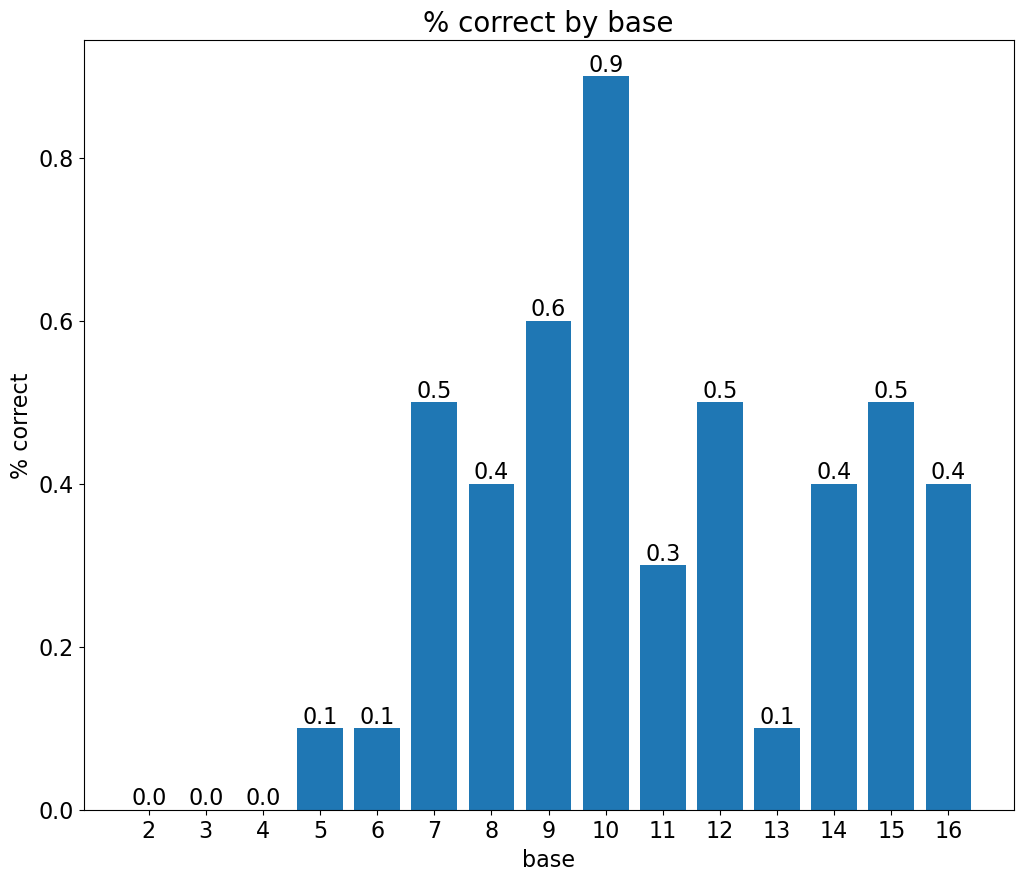

In [8]:
## percent correct by base
correctness_by_base = {base: 0 for base in bases}
for data in graded_data:
    correctness_by_base[data['base']] += data['y_graded']['y_correct']
correctness_by_base = [correctness_by_base[base]/num_from_dataset for base in bases]

plt.figure(figsize=(12, 10))
bars = plt.bar(bases, correctness_by_base)
plt.title('% correct by base', fontsize=20)
plt.xticks(bases, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('base', fontsize=16)
plt.ylabel('% correct', fontsize=16)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, yval, yval, ha='center', va='bottom', fontsize=16)
plt.savefig(f'analysis_plots/{session}/{format}/percent_correct_by_base.png')
plt.show()

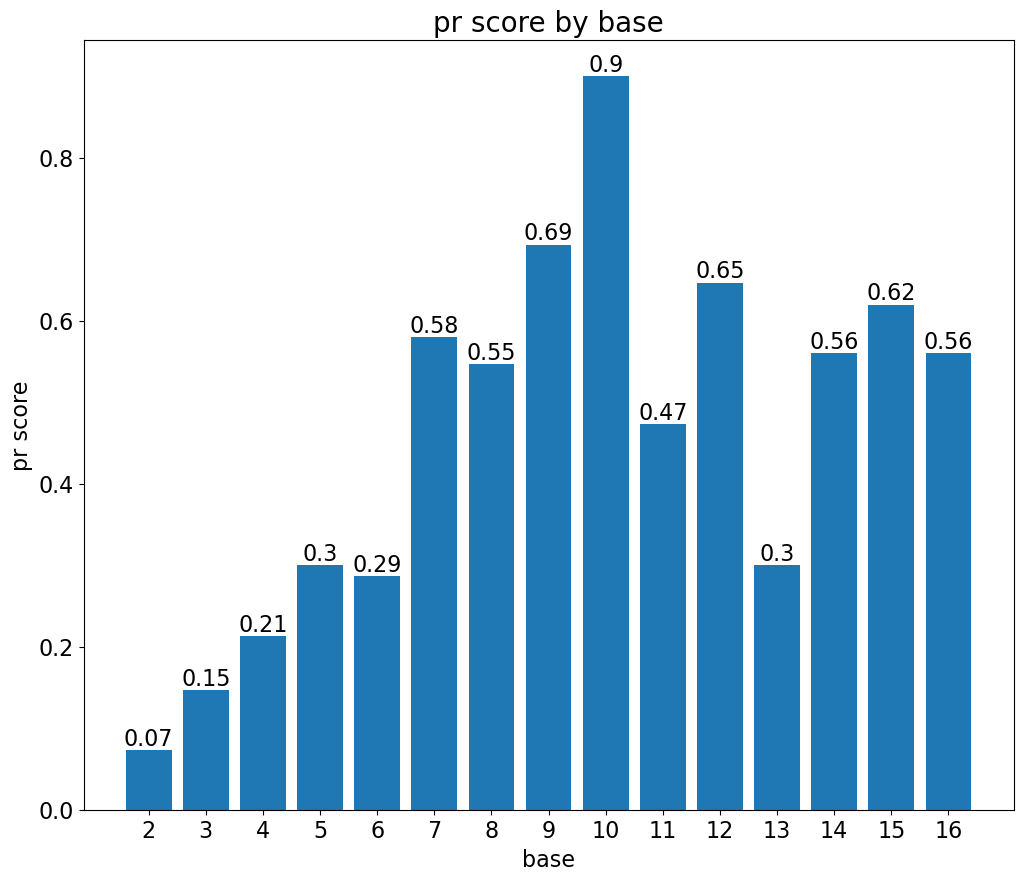

In [9]:
## percent correct by base & average pr score by base
mean_pr_score_by_base = {base: 0 for base in bases}
for data in graded_data:
    mean_pr_score_by_base[data['base']] += data['y_graded']['pr_score']
mean_pr_score_by_base = [mean_pr_score_by_base[base]/num_from_dataset for base in bases]

plt.figure(figsize=(12, 10))
bars = plt.bar(bases, mean_pr_score_by_base)
plt.title('pr score by base', fontsize=20)
plt.xticks(bases, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('base', fontsize=16)
plt.ylabel('pr score', fontsize=16)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=16)
plt.savefig(f'analysis_plots/{session}/{format}/pr_score_by_base.png')
plt.show()

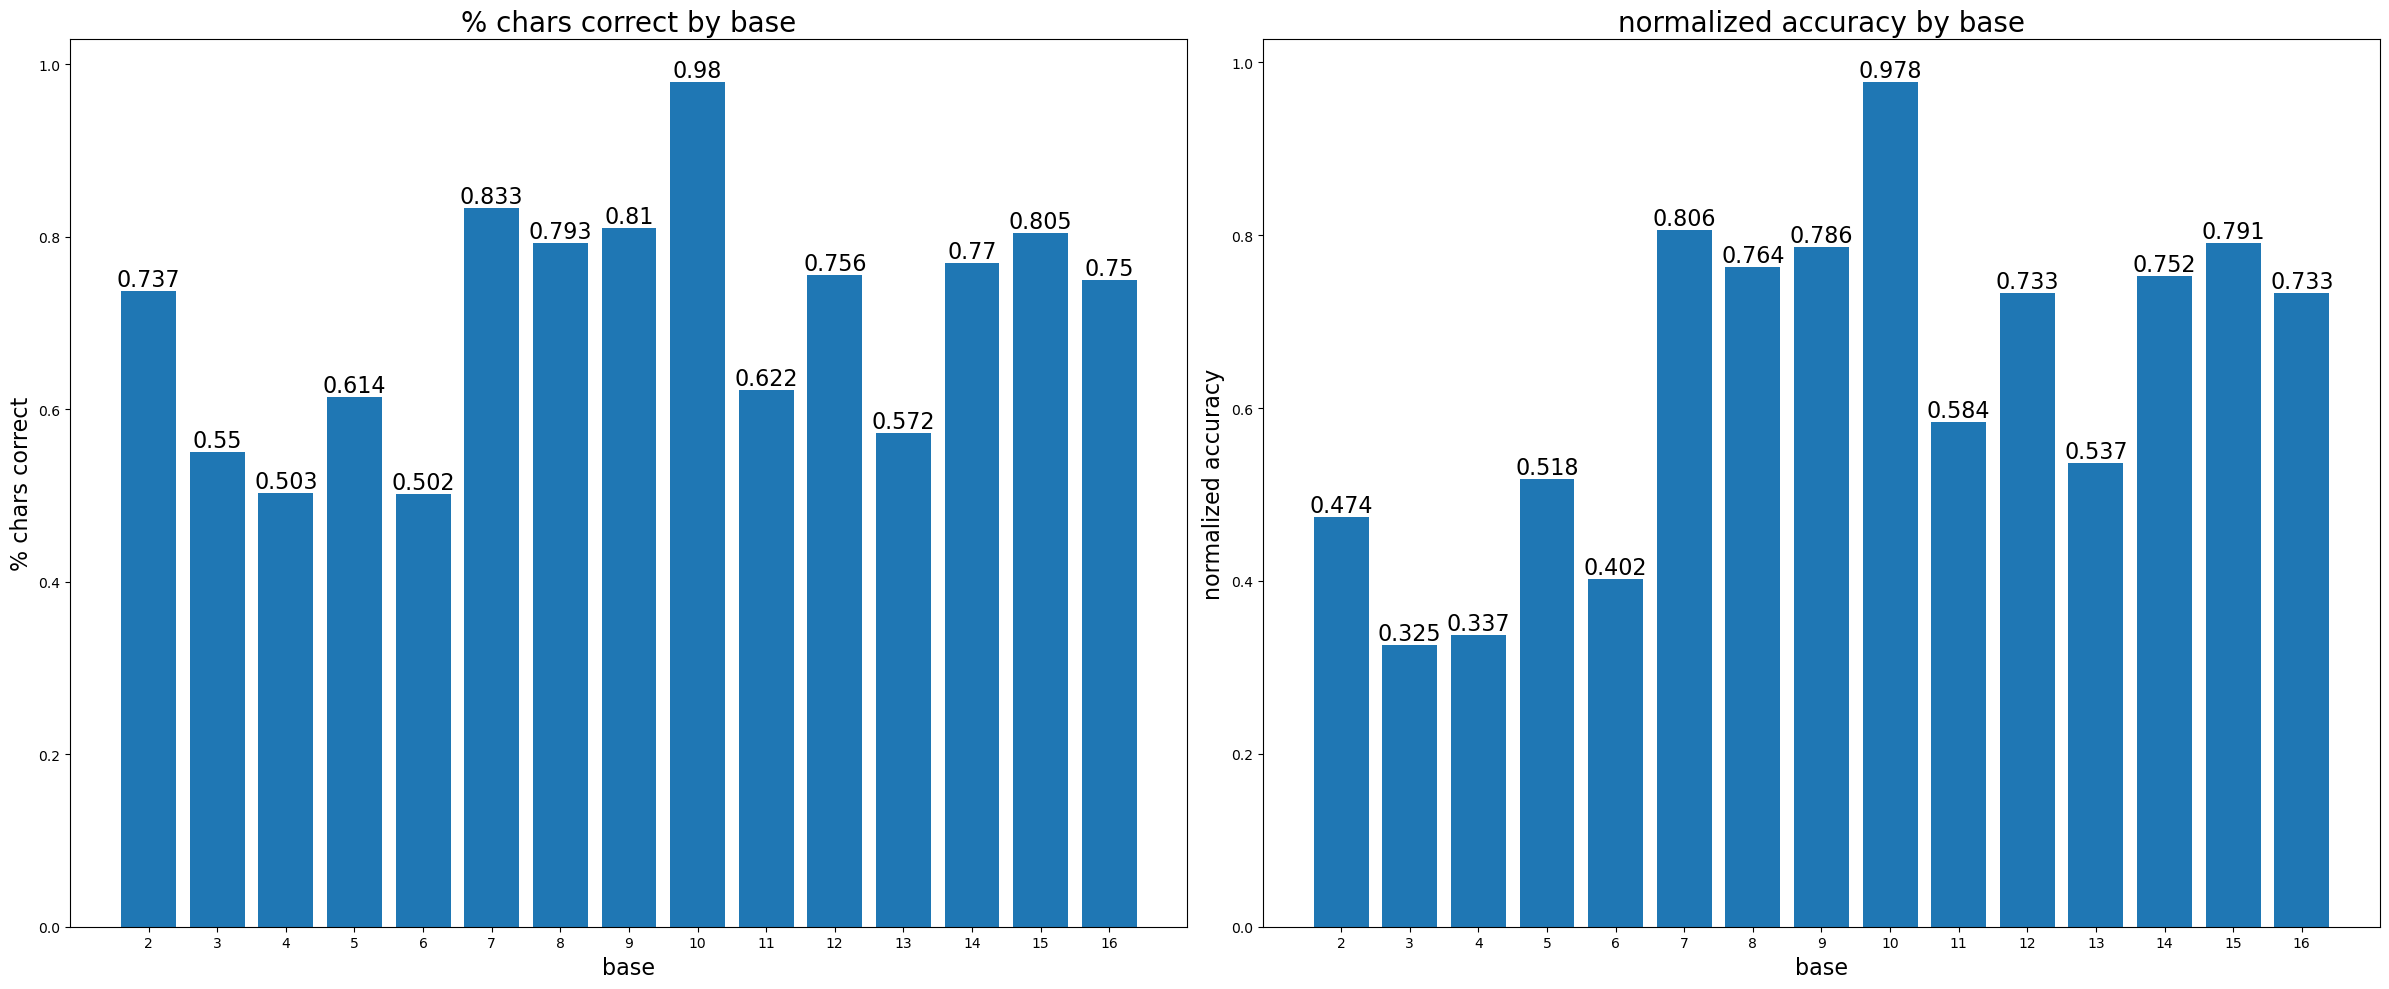

*percent of characters correct is calculated first for each response, then averaged
*responses that contain invalid digits (for example '2' in a base 2 number) are not included in this data


In [10]:
## number of digits wrong
percent_chars_correct_by_base = {base: [] for base in bases}
for data in graded_data:
    if not data['final_answer_correct_base']:
        continue
    percent_chars_correct_by_base[data['base']].append(data['percent_chars_correct'])
percent_chars_correct_by_base = {base: sum(percent_chars_correct_by_base[base])/len(percent_chars_correct_by_base[base]) for base in bases}

fig, axs = plt.subplots(1, 2, figsize=(24, 10))
bars1 = axs[0].bar(bases, list(percent_chars_correct_by_base.values()))
axs[0].set_title('% chars correct by base', fontsize=20)
axs[0].set_xticks(bases)
axs[0].set_xlabel('base', fontsize=16)
axs[0].set_ylabel('% chars correct', fontsize=16)
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x()+bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=16)

bars2 = axs[1].bar(bases, [(percent_chars_correct_by_base[base]-1/base) / (1-1/base) for base in bases])
axs[1].set_title('normalized accuracy by base', fontsize=20)
axs[1].set_xticks(bases)
axs[1].set_xlabel('base', fontsize=16)
axs[1].set_ylabel('normalized accuracy', fontsize=16)
for bar in bars2:
    xval = bar.get_x()+bar.get_width()/2
    yval = bar.get_height()
    if yval >= 0:
        axs[1].text(xval, yval, round(yval, 3), ha='center', va='bottom', fontsize=16)
    else:
        axs[1].text(xval, yval, round(yval, 3), ha='center', va='top', fontsize=16)
plt.tight_layout()
plt.savefig(f'analysis_plots/{session}/{format}/percent_chars_correct_by_base.png')
plt.show()
print("*percent of characters correct is calculated first for each response, then averaged")
print("*responses that contain invalid digits (for example '2' in a base 2 number) are not included in this data")

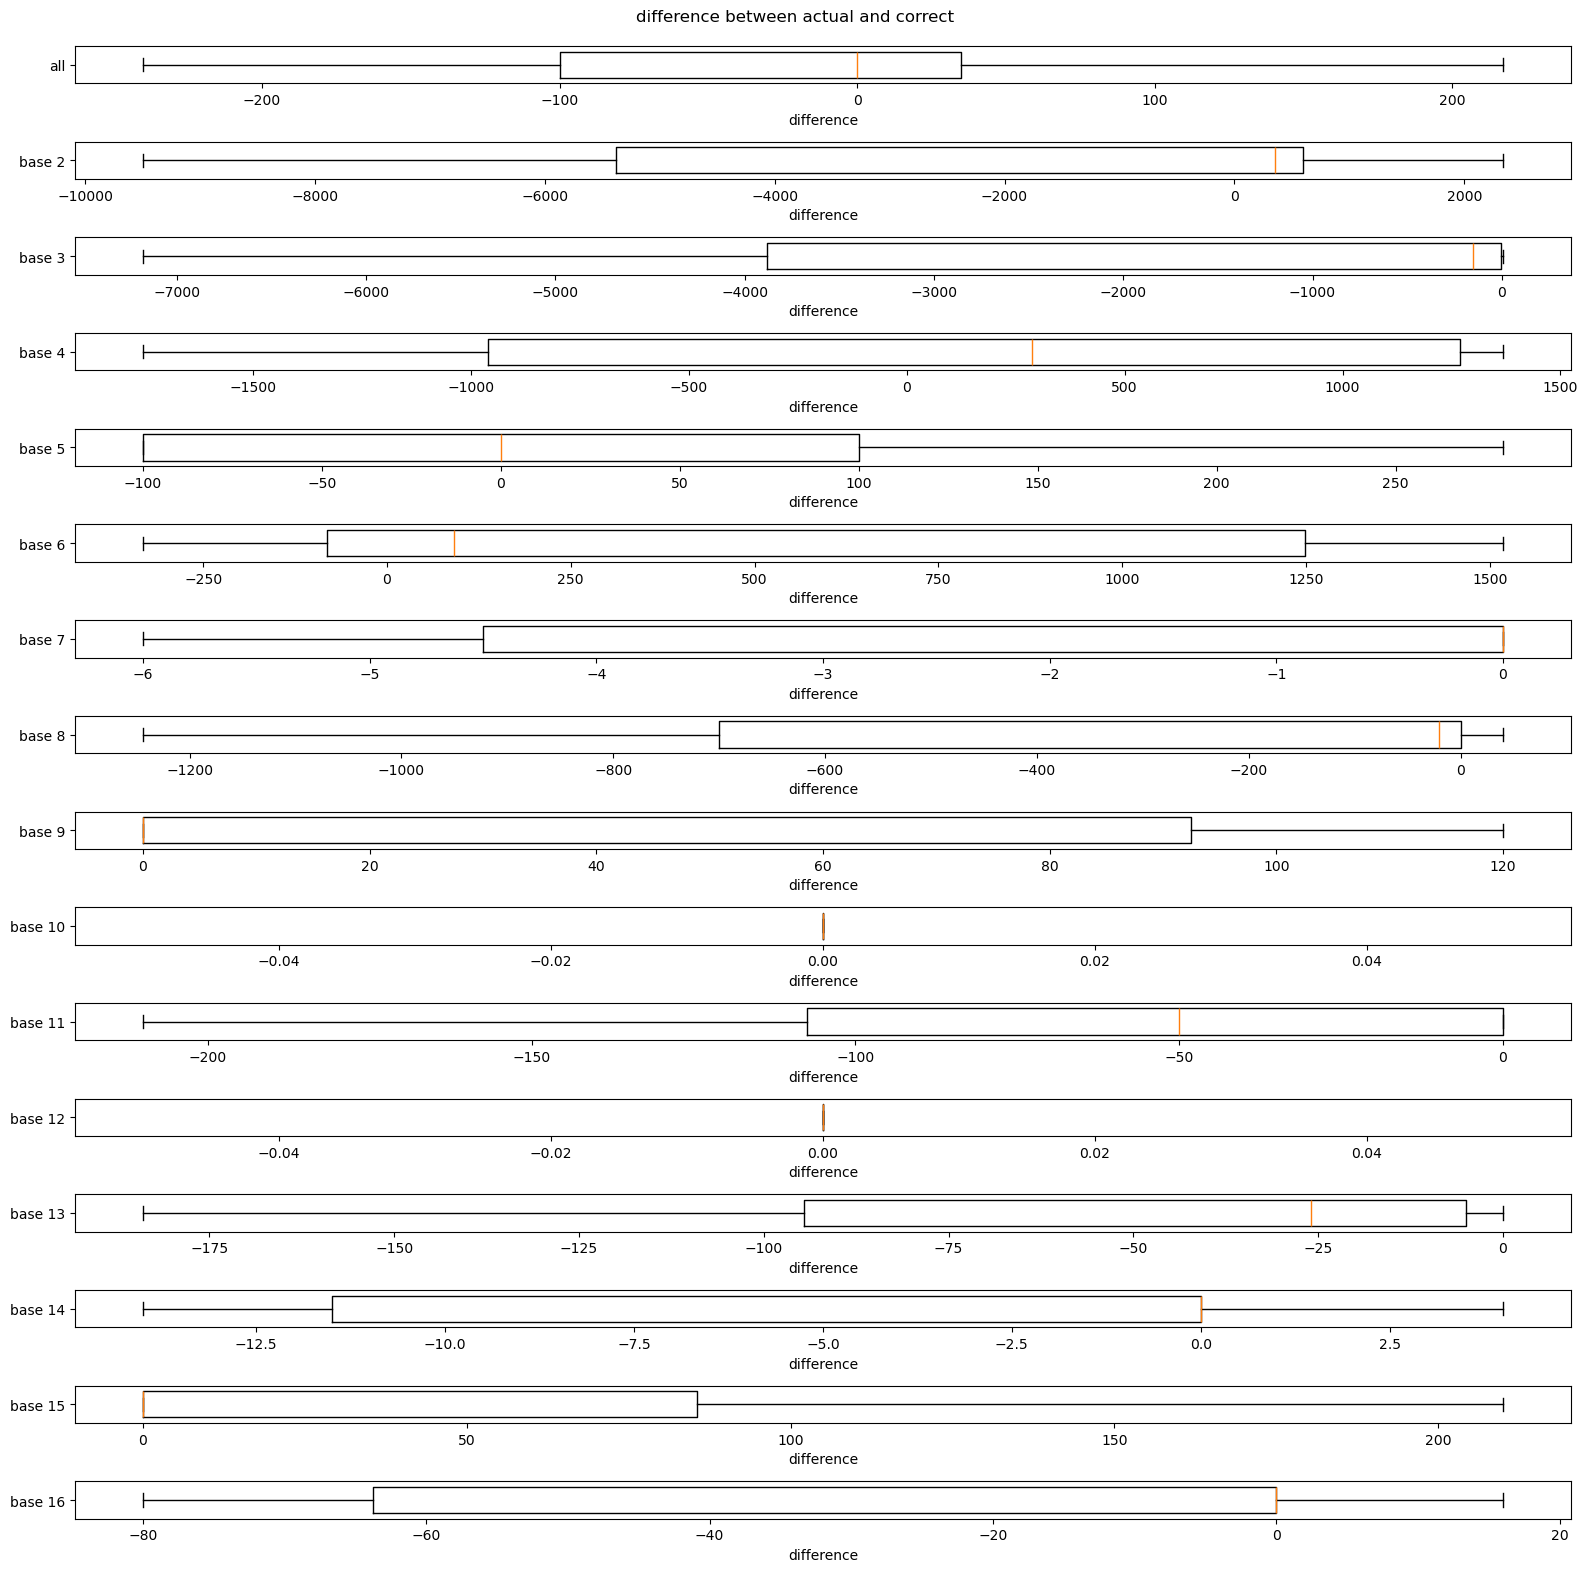

base 2: 
	invalid numbers: 0
	difference list: [-24576, -9496, -7168, -24, 217, 496, 512, 624, 2336, 134400]
	average: 9732.1
	median: 356.5
base 3: 
	invalid numbers: 0
	difference list: [-30949, -7179, -4556, -1863, -181, -123, -33, 6, 91856, 100824]
	average: 14780.2
	median: -152.0
base 4: 
	invalid numbers: 0
	difference list: [-4882, -1752, -1276, -10, 240, 336, 976, 1368, 64896, 70740]
	average: 13063.6
	median: 288.0
base 5: 
	invalid numbers: 1
	difference list: [-2280, -2265, -100, -100, 0, 35, 100, 280, 21765]
	average: 1937.2222222222222
	median: 0
base 6: 
	invalid numbers: 0
	difference list: [-4604, -332, -100, -26, 0, 181, 440, 1518, 7736, 256592]
	average: 26140.5
	median: 90.5
base 7: 
	invalid numbers: 0
	difference list: [-1176, -588, -6, 0, 0, 0, 0, 0, 96, 132]
	average: -154.2
	median: 0.0
base 8: 
	invalid numbers: 0
	difference list: [-8192, -1244, -896, -112, -40, 0, 0, 0, 0, 40]
	average: -1044.4
	median: -20.0
base 9: 
	invalid numbers: 0
	difference list: [0

In [11]:
## difference between final answer and correct answer
difference_by_base = {base: [] for base in bases}
for data in graded_data:
    if data['difference'] != math.inf:
        difference_by_base[data['base']].append(data['difference'])

data = list(difference_by_base.values())
data.insert(0, [difference for base in bases for difference in difference_by_base[base]])
labels = list(difference_by_base.keys())
labels.append('all')
fig, ax = plt.subplots(16, 1, figsize=(16, 16))
fig.suptitle('difference between actual and correct')
for i in range(16):
    ax[i].boxplot(data[i], widths=0.7, vert=False, showfliers=False)
    ax[i].set_xlabel('difference')
    ax[i].set_yticks(ticks=[1], labels=[f"base {i+1}"])
ax[0].set_yticks(ticks=[1], labels=['all'])
plt.tight_layout(rect=(0, 0, 1, 0.985))
plt.savefig(f'analysis_plots/{session}/{format}/difference_by_base.png')
plt.show()

for base in bases:
    ls = difference_by_base[base]
    ls.sort()
    print(f"base {base}: ")
    print(f"\tinvalid numbers: {num_from_dataset-len(difference_by_base[base])}")
    print(f"\tdifference list: {ls}")
    print(f"\taverage: {sum(ls)/len(ls)}")
    print(f"\tmedian: {statistics.median(ls)}")

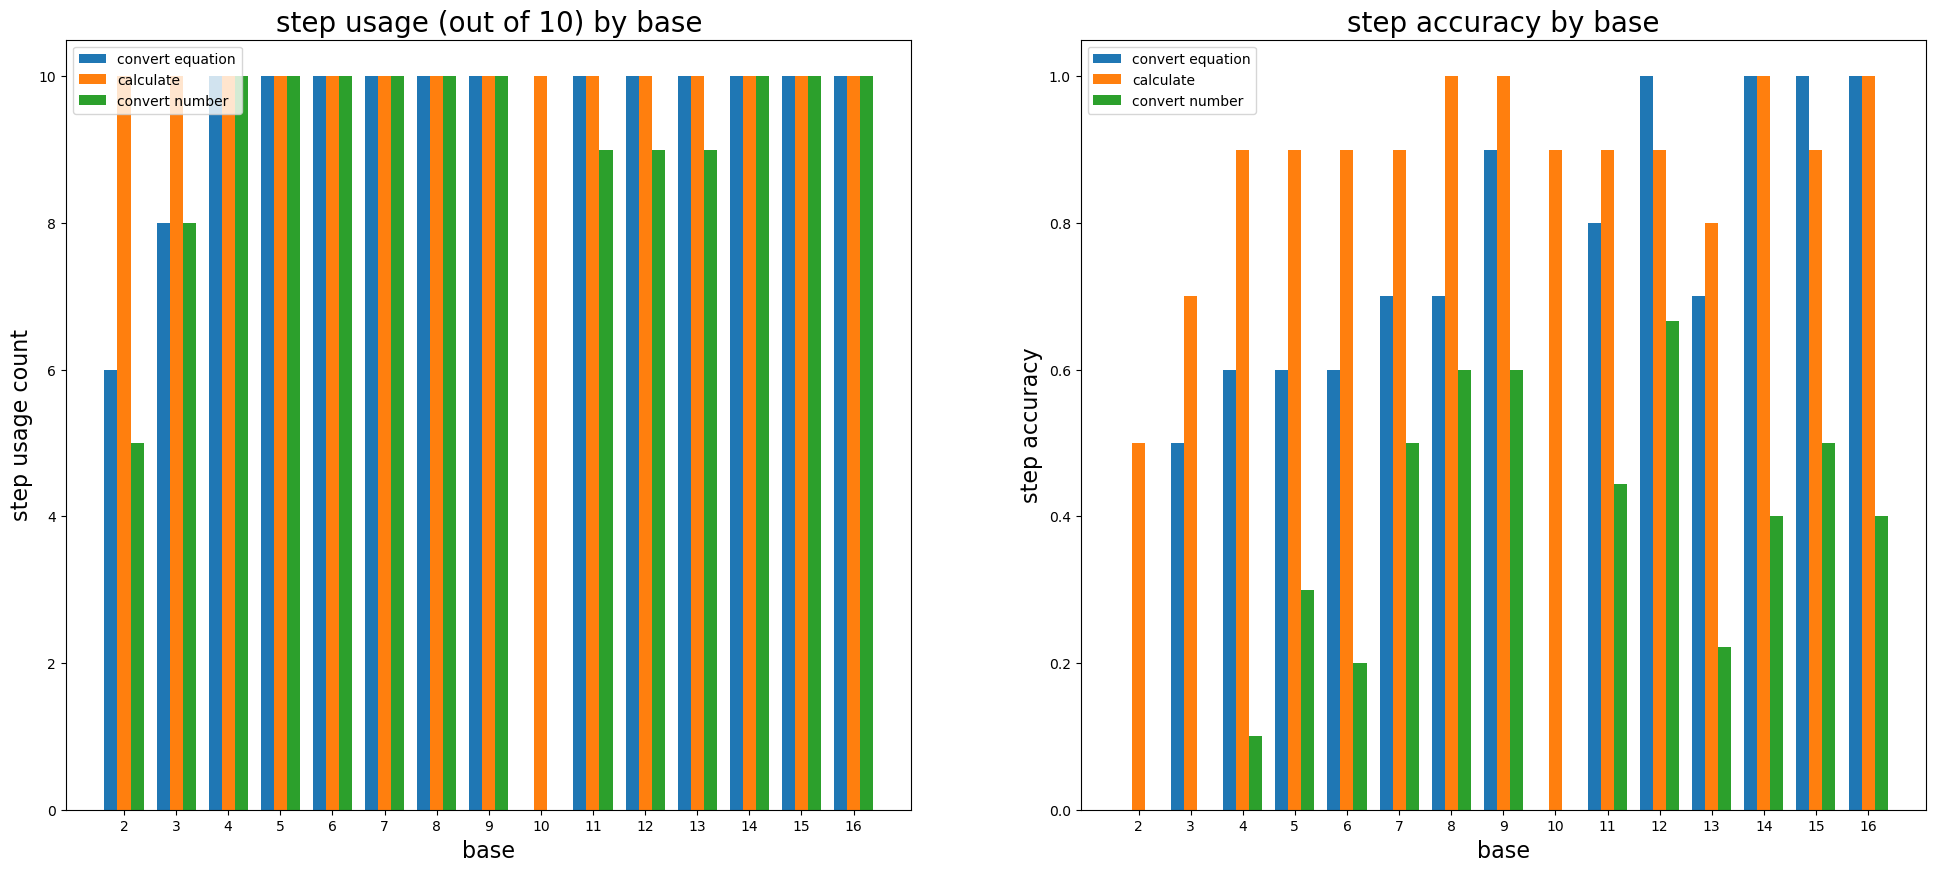

In [12]:
# compare steps' accuracy
step_usage_by_base = {step: [0 for base in bases] for step in steps}  # stored opposite for plot
step_accuracy_by_base = {step: [0 for base in bases] for step in steps}  # stored opposite for plot
for data in graded_data:
    base = data['base']
    steps_correctness = data['steps_correctness']
    for step in steps_correctness:
        step_usage_by_base[step[0]][base-2] += 1
        step_accuracy_by_base[step[0]][base-2] += step[1]
for step in steps:
    for base in bases:
        if step_usage_by_base[step][base-2] != 0:
            step_accuracy_by_base[step][base-2] /= step_usage_by_base[step][base-2]

fig, axs = plt.subplots(1, 2, figsize=(24, 10))
x_axis = np.arange(len(bases))
axs[0].bar(x_axis-0.25, step_usage_by_base[steps[0]], 0.25, label=steps[0])
axs[0].bar(x_axis, step_usage_by_base[steps[1]], 0.25, label=steps[1])
axs[0].bar(x_axis+0.25, step_usage_by_base[steps[2]], 0.25, label=steps[2])
axs[0].set_title(f'step usage (out of {num_from_dataset}) by base', fontsize=20)
axs[0].set_xlabel('base', fontsize=16)
axs[0].set_ylabel('step usage count', fontsize=16)
axs[0].set_xticks(x_axis, bases)
axs[0].legend()

axs[1].bar(x_axis-0.25, step_accuracy_by_base[steps[0]], 0.25, label=steps[0])
axs[1].bar(x_axis, step_accuracy_by_base[steps[1]], 0.25, label=steps[1])
axs[1].bar(x_axis+0.25, step_accuracy_by_base[steps[2]], 0.25, label=steps[2])
axs[1].set_title('step accuracy by base', fontsize=20)
axs[1].set_xlabel('base', fontsize=16)
axs[1].set_ylabel('step accuracy', fontsize=16)
axs[1].set_xticks(x_axis, bases)
axs[1].legend()
plt.savefig(f'analysis_plots/{session}/{format}/step_analysis_by_base.png')
plt.show()

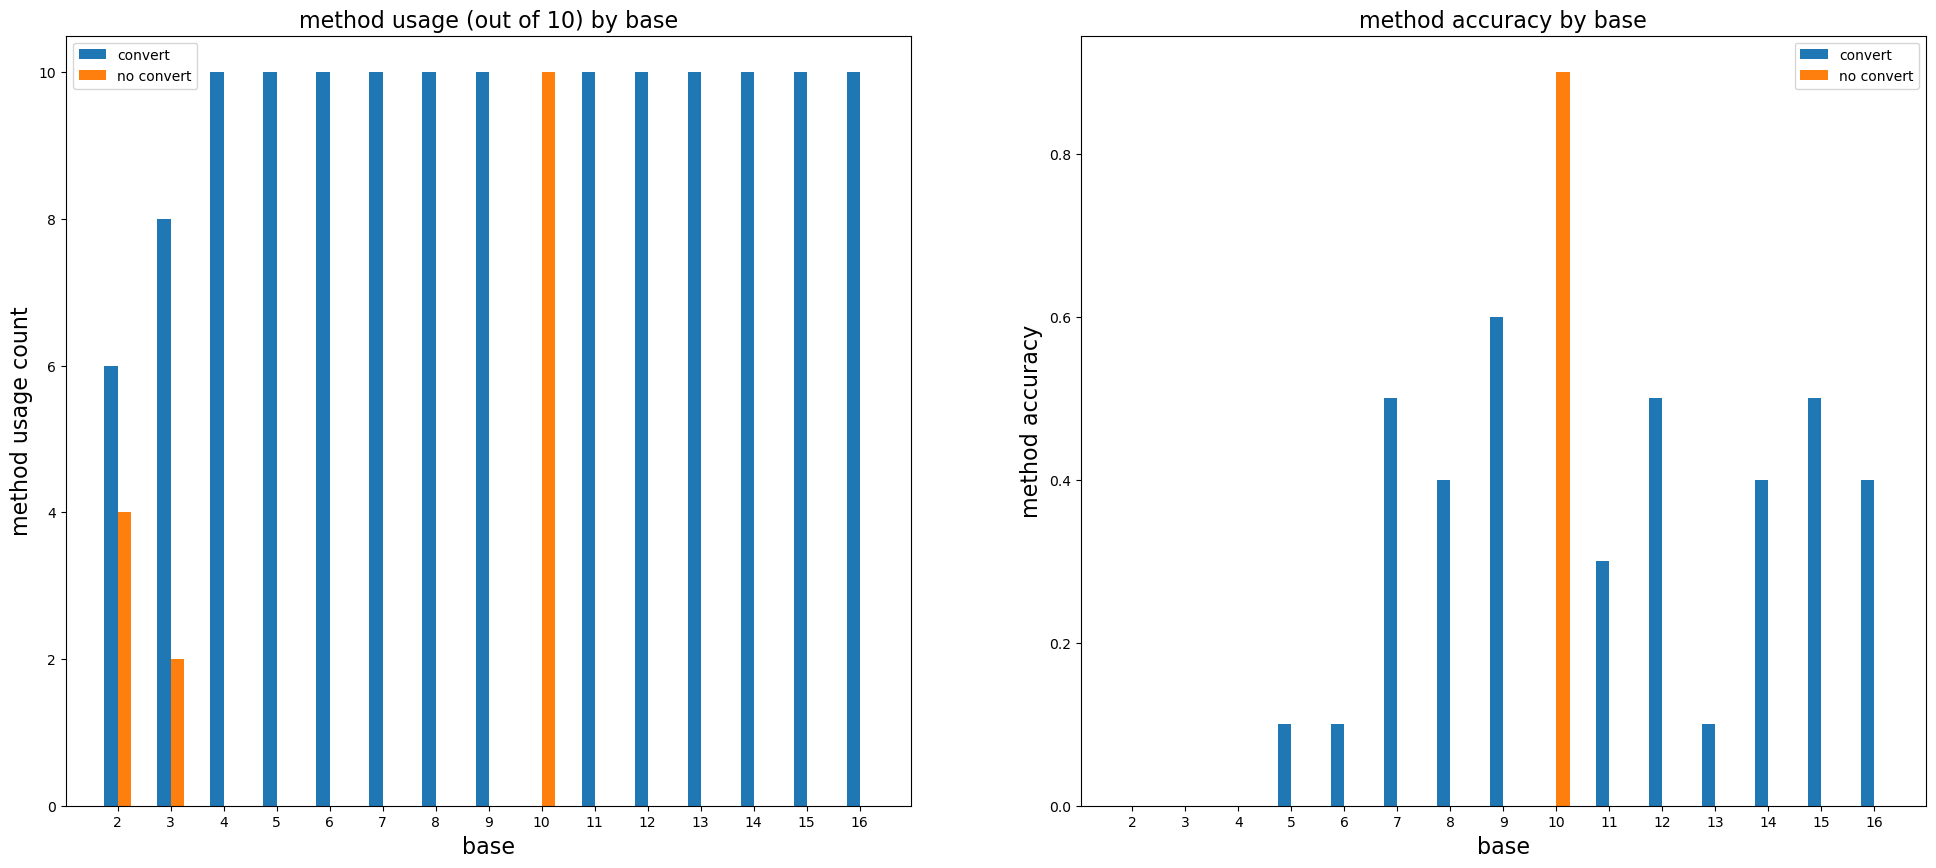

In [13]:
# compare two methods' accuracy
methods = ['convert', 'no convert']
method_usage_by_base = {method: [0 for base in bases] for method in methods}  # stored opposite for plot
method_accuracy_by_base = {method: [0 for base in bases] for method in methods}  # stored opposite for plot
for data in graded_data:
    base = data['base']
    method = [step[0] for step in data['steps_correctness']]
    if steps[0] in method or steps[2] in method:
        method_usage_by_base[methods[0]][base-2] += 1
        method_accuracy_by_base[methods[0]][base-2] += data['y_graded']['y_correct']
    else:
        method_usage_by_base[methods[1]][base-2] += 1
        method_accuracy_by_base[methods[1]][base-2] += data['y_graded']['y_correct']
for method in methods:
    for base in bases:
        if method_usage_by_base[method][base-2] != 0:
            method_accuracy_by_base[method][base-2] /= method_usage_by_base[method][base-2]

fig, axs = plt.subplots(1, 2, figsize=(24, 10))
x_axis = np.arange(len(bases))
axs[0].bar(x_axis-0.125, method_usage_by_base[methods[0]], 0.25, label=methods[0])
axs[0].bar(x_axis+0.125, method_usage_by_base[methods[1]], 0.25, label=methods[1])
axs[0].set_title(f'method usage (out of {num_from_dataset}) by base', fontsize=16)
axs[0].set_xlabel('base', fontsize=16)
axs[0].set_ylabel('method usage count', fontsize=16)
axs[0].set_xticks(x_axis, bases)
axs[0].legend()
axs[1].bar(x_axis-0.125, method_accuracy_by_base[methods[0]], 0.25, label=methods[0])
axs[1].bar(x_axis+0.125, method_accuracy_by_base[methods[1]], 0.25, label=methods[1])
axs[1].set_title('method accuracy by base', fontsize=16)
axs[1].set_xlabel('base', fontsize=16)
axs[1].set_ylabel('method accuracy', fontsize=16)
axs[1].set_xticks(x_axis, bases)
axs[1].legend()
plt.savefig(f'analysis_plots/{session}/{format}/method_analysis_by_base.png')
plt.show()